In [1]:
#load packages
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import time
notebookstart= time.time()

In [2]:
#load training data (predictions from all first-level models)
NN_trainpred = pd.read_csv('NN_train.csv')
XGB_trainpred = pd.read_csv('XGB_train.csv')
Ridge_trainpred = pd.read_csv('ridgetrain.csv')
NF_data = pd.read_csv('finaltrain.csv')

In [8]:
#Drop extra columns from NF_data
NF_data = NF_data[['item_id', 'image_top_1', 'city', 'price', 'region']]
NF_data.head()

,item_id,image_top_1,city,price,region
0,b912c3c6a6ad,13,460,5.991467,19
1,2dac0150717d,2722,1300,8.006368,17
2,ba83aefab5dc,2260,1276,8.294050,16
3,02996f1dd2ea,2837,940,7.696213,21
4,7c90be56d2ab,1408,317,10.596635,4


In [9]:
#clean and combine datasets
Ridge_trainpred.columns = ['item_id', 'Ridge_prediction']
NN_trainpred.columns = ['item_id', 'NN_prediction']
XGB_trainpred.columns = ['item_id', 'deal_probability', 'XGB_prediction']

StackData = pd.merge(Ridge_trainpred, NN_trainpred, on='item_id')
StackData = pd.merge(StackData, XGB_trainpred, on='item_id')
StackData = pd.merge(StackData, NF_data, on='item_id')

StackData = StackData.set_index(['item_id'])     #make 'item_id' index to exclude it from analysis

StackData.head()

,Ridge_prediction,NN_prediction,deal_probability,XGB_prediction,image_top_1,city,price,region
item_id,,,,,,,,
b912c3c6a6ad,0.110323,0.215137,0.12789,0.067046,13,460,5.991467,19
2dac0150717d,0.188261,0.202056,0.00000,0.154116,2722,1300,8.006368,17
ba83aefab5dc,0.192077,0.439474,0.43177,0.208998,2260,1276,8.294050,16
02996f1dd2ea,0.294288,0.282677,0.80323,0.297899,2837,940,7.696213,21
7c90be56d2ab,0.338803,0.291762,0.20797,0.355725,1408,317,10.596635,4


In [10]:
#prepare for LGB model
y = StackData.deal_probability.copy()
traindex = StackData.index
StackData.drop("deal_probability",axis=1, inplace=True)

In [11]:
#set up data and parameters for LGB model
X_train, X_valid, y_train, y_valid = train_test_split(
    StackData, y, test_size=0.10, random_state=23)

lgbm_params =  {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'max_depth': 15,
    'num_leaves': 37,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.8,
    # 'bagging_freq': 5,
    'learning_rate': 0.019,
    'verbose': 0
}  

features = ['Ridge_prediction', 'NN_prediction', 'XGB_prediction', 'image_top_1', 'city', 'price', 'region']

lgtrain = lgb.Dataset(X_train, y_train,
                feature_name=features)
lgvalid = lgb.Dataset(X_valid, y_valid,
                feature_name=features)

In [14]:
#train model
modelstart = time.time()
lgb_clf = lgb.train(
    lgbm_params,
    lgtrain,
    num_boost_round=16000,
    valid_sets=[lgtrain, lgvalid],
    valid_names=['train','valid'],
    early_stopping_rounds=200,
    verbose_eval=200
)

Training until validation scores don't improve for 200 rounds.
[200]	train's rmse: 0.224368	valid's rmse: 0.225816
[400]	train's rmse: 0.223523	valid's rmse: 0.225195
[600]	train's rmse: 0.223111	valid's rmse: 0.224963
[800]	train's rmse: 0.222789	valid's rmse: 0.224828
[1000]	train's rmse: 0.222517	valid's rmse: 0.224735
[1200]	train's rmse: 0.222251	valid's rmse: 0.224641
[1400]	train's rmse: 0.222007	valid's rmse: 0.224568
[1600]	train's rmse: 0.221764	valid's rmse: 0.224494
[1800]	train's rmse: 0.221551	valid's rmse: 0.224439
[2000]	train's rmse: 0.221318	valid's rmse: 0.224367
[2200]	train's rmse: 0.221085	valid's rmse: 0.224289
[2400]	train's rmse: 0.220879	valid's rmse: 0.224244
[2600]	train's rmse: 0.220683	valid's rmse: 0.224203
[2800]	train's rmse: 0.220495	valid's rmse: 0.224168
[3000]	train's rmse: 0.220303	valid's rmse: 0.224137
[3200]	train's rmse: 0.220134	valid's rmse: 0.224113
[3400]	train's rmse: 0.219959	valid's rmse: 0.224085
[3600]	train's rmse: 0.21978	valid's rms

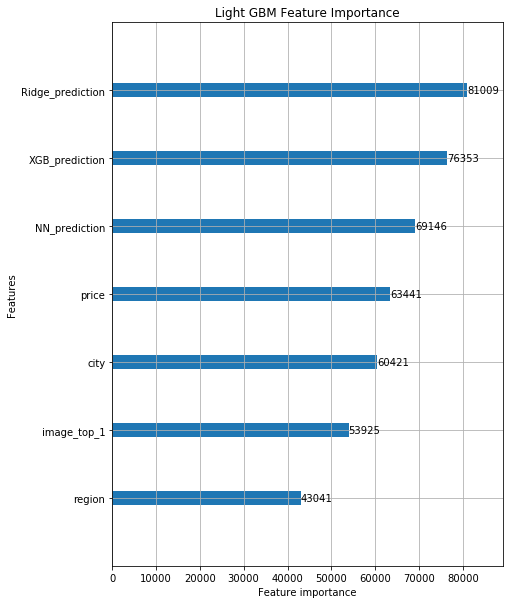

In [15]:
# Feature Importance Plot
import matplotlib.pyplot as plt
%matplotlib inline

f, ax = plt.subplots(figsize=[7,10])
lgb.plot_importance(lgb_clf, max_num_features=50, ax=ax)
plt.title("Light GBM Feature Importance")

In [16]:
#load/prepare test data (to generate predictions)
NN_testpred = pd.read_csv('NN_test.csv')
XGB_testpred = pd.read_csv('XGB_test.csv')
Ridge_testpred = pd.read_csv('ridgetest.csv')
NF_test = pd.read_csv('finaltest.csv')
NF_test = NF_test[['item_id', 'image_top_1', 'city', 'price', 'region']]   #Drop extra columns from NF_data

In [25]:
#clean and combine test data
Ridge_testpred.columns = ['item_id', 'Ridge_prediction']
NN_testpred.columns = ['item_id', 'NN_prediction']
XGB_testpred = XGB_testpred[['item_id', 'deal_probability']]
XGB_testpred.columns = ['item_id', 'XGB_prediction']

StackTest = pd.merge(Ridge_testpred, NN_testpred, on='item_id')
StackTest = pd.merge(StackTest, XGB_testpred, on='item_id')
StackTest = pd.merge(StackTest, NF_test, on='item_id')

StackTest = StackTest.set_index(['item_id'])   #make 'item_id' index to exclude it from analysis

StackTest.head()

,Ridge_prediction,NN_prediction,XGB_prediction,image_top_1,city,price,region
item_id,,,,,,,
6544e41a8817,0.388276,0.035646,0.053024,1137,306,-999.000000,4
65b9484d670f,0.439667,0.146205,0.271194,0,933,8.006368,19
8bab230b2ecd,0.164396,0.124684,0.173762,2169,147,9.615806,12
8e348601fefc,0.158002,0.156154,0.190529,0,1238,8.411833,18
8bd2fe400b89,0.250707,0.363657,0.249323,7,236,8.496991,14


In [32]:
#apply model to test data
StackTest['lgb_pred'] = lgb_clf.predict(StackTest)

In [61]:
#create final df of output
LGBtestpred = StackTest[['lgb_pred']]
LGBtestpred = LGBtestpred.reset_index()
LGBtestpred.head()

,item_id,lgb_pred
0,6544e41a8817,0.324078
1,65b9484d670f,0.236019
2,8bab230b2ecd,0.119132
3,8e348601fefc,0.151832
4,8bd2fe400b89,0.262246


In [63]:
#export to csv and txt
LGBtestpred.to_csv("LGBtestpred.csv", index=False)
LGBtestpred.to_csv("LGBtestpred.txt", index=False)
